In [1]:
# Required Imports
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import pandas as pd
import re as re
import requests
from urllib import request
from lxml import html
import spacy 
from spacy_langdetect import LanguageDetector
from spacy.language import Language
from spacy import displacy
from collections import Counter
import en_core_web_sm
from pprint import pprint
import unicodedata2 as unicodedata
import inflect
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import contractions
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#accessing Chromedriver
driver = webdriver.Chrome('chromedriver')

#Open login page
driver.get('https://www.linkedin.com/')

from selenium.webdriver.common.by import By
# locate submit button by_xpath
xpath = '/html/body/nav/div/a[2]'

#sign_in_button = driver.find_element_by_xpath('/html/body/nav/div/a[2]') 
sign_in_button = driver.find_element(by=By.XPATH, value=xpath)

# .click() to mimic button click
sign_in_button.click()

time.sleep(5)

# locate email form by_class_name
username = driver.find_element(by=By.XPATH, value = '//*[@id="username"]')

# send_keys() to simulate key strokes
username.send_keys('')

# locate password form by_class_name
password = driver.find_element(by=By.XPATH, value = '//*[@id="password"]')

# send_keys() to simulate key strokes
password.send_keys('')

login = driver.find_element(by=By.XPATH, value = '//*[@id="organic-div"]/form/div[3]/button')
login.click()

time.sleep(5)

#make a request to the webpage, and grab the html respone
driver.get("https://www.linkedin.com/mynetwork/invite-connect/connections/")
html = driver.page_source
soup = BeautifulSoup(html,'html.parser')

tes = soup.findAll('code')
tes = str(tes)

lnk = list(re.finditer(r'publicIdentifier":"(.*?)"},{"lastName', tes))
lnk1 = list(re.finditer(r'publicIdentifier(.*?)createdAt', tes))
lnk2 = str(lnk1[1].group(1))[28072:]
lnk2 = lnk2.strip('},{"')

nlist = []
for i in range(len(lnk)):
    nlist.append(lnk[i].group(1))
nlist.append(lnk2)

#sample list of 2 connections
tlist = nlist[0:2]

tdict={v: k for v, k in enumerate(nlist)}


hh = {}


for k,v in tdict.items():

    driver.get("https://www.linkedin.com/in/{}/recent-activity/".format(v))
    last_height = driver.execute_script("return document.body.scrollHeight")

    while True:

        # Scroll down to the bottom.
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait to load the page.
        time.sleep(2)

        # Calculate new scroll height and compare with last scroll height.
        new_height = driver.execute_script("return document.body.scrollHeight")

        if new_height == last_height:
            hh[v] = driver.page_source
            break

        last_height = new_height
        time.sleep(2)

    time.sleep(5)

    
tss = {}
p = {}

for k, v in hh.items():
    tss[k] = BeautifulSoup(hh[k], 'lxml')
    p[k] = tss[k].findAll("div", attrs = {"class" : "feed-shared-update-v2__description-wrapper"})
    

#newD = [[k,re.search(r'ltr(.*?)span',str(v))[1].strip('"></')] for k, values in p.items() for v in values]

#rr = pd.DataFrame(newD, columns=['name','text'])
    

In [ ]:
newD = [[k,v] for k, values in p.items() for v  in values]
rr = pd.DataFrame(newD, columns=['name','text'])
rr.text = rr.text.astype(str)
rr.to_csv('linkedintext.csv')

In [3]:
@Language.factory('language_detector')
def language_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load('en_core_web_sm')
nlp.max_length = 2000000
nlp.add_pipe('language_detector', last=True)


#nlp.add_pipe(LanguageDetector(), last=True)
text = 'This is an english text.'
doc = nlp(text)
# document level language detection. Think of it like average language of the document!
print(doc._.language)
# sentence level language detection
for sent in doc.sents:
   print(sent, sent._.language)

{'language': 'en', 'score': 0.9999980402736035}
This is an english text. {'language': 'en', 'score': 0.9999947690751241}


In [4]:
text = rr['text']
#Load model
nlp = spacy.load("en_core_web_sm")

text0 = nlp(text[0])

pprint([(word, word.label_) for word in text0.ents])

[(22, 'CARDINAL'),
 (urn%3Ali%3Aactivity%3A6917721430004518912">#assurance</a, 'CARDINAL')]


In [5]:
class TextProcessing:
    '''Basic text processing
    Parameters
    ----------
    words: str
        text to be processed
    Return
    ----------
    words: str
        processed text
    '''

    def __init__(self):
        pass

    def remove_html(self, words):
        '''Remove message with html'''
        return re.sub(r'^<p.*</p>', '', words)

    def replace_contractions(self, text):
        """Replace contractions in string of text"""
        return contractions.fix(text)

    def remove_URL(self, sample):
        """Remove URLs from a sample string"""
        return re.sub(r"http\S+", "", sample)

    def remove_non_ascii(self, words):
        """Remove non-ASCII characters from list of tokenized words"""
        return [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in words]

    def to_lowercase(self, words):
        """Convert all characters to lowercase from list of tokenized words"""
        return [word.lower() for word in words]

    def remove_punctuation(self, words):
        """Remove punctuation from list of tokenized words"""
        return [re.sub(r'[^\w\s]', '', word) for word in words]

    def replace_numbers(self, words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        return [p.number_to_words(word) if word.isdigit() else word for word in words]

    def remove_stopwords(self, words):
        """Remove stop words from list of tokenized words"""
        return [word for word in words if word not in stopwords.words('english')]

    def stem_words(self, words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        return [stemmer.stem(word) for word in words]

    def lemmatize_verbs(self, words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word, pos='v') for word in words]

    def normalize(self, words):
        words = self.remove_non_ascii(words)
        words = self.to_lowercase(words)
        words = self.remove_punctuation(words)
        words = self.replace_numbers(words)
        words = self.remove_stopwords(words)
        # Remove space
        words = ' '.join(words).replace('  ', ' ').strip().split(' ')
        try:
            words.remove('')
        except:
            pass

        return words

    def preprocess(self, sample):
        sample = self.remove_html(sample)
        sample = self.remove_URL(sample)
        sample = self.replace_contractions(sample)
        # Tokenize
        words = nltk.word_tokenize(sample)

        # Normalize
        words = self.normalize(words)
        # return sample
        return ' '.join(words)

In [6]:
preprocessor = TextProcessing()
processed = [preprocessor.preprocess(t) for t in text]

# Remove empty string
while("" in processed):
    processed.remove("")

In [7]:
def counter_to_df(counter):
    counter_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()\
    .rename(columns={0:'Count'}).sort_values(by='Count', ascending=False)

    return counter_df

word_counter = Counter(' '.join(processed).split())

# Count the occurence of words
wordcounter_df = counter_to_df(word_counter)

wordcounter_df['name'] = wordcounter_df['index'].astype('str')
wclist = wordcounter_df.name.to_list()
print(wclist)

['div', 'class', 'span', 'br', 'href', 'dataattributeindex', 'button', 'feedsharedinlineshowmoretext', 'tabindex', 'dir', 'ltr', 'zero', 'one', 'see', 'urn', 'li', 'dataentitytype', 'dataentityhovercardid', 'style', 'breakwords', 'feedsharedupdatev2__descriptionwrapper', 'relative', 'feedsharedtext', 'minimalpadding', 'feedsharedupdatev2__description', 'feedsharedupdatev2__commentary', 'two', 'role', 'already', 'light', 'content', 'type', 'visually', 'screen', 'detected', 'tblack', 'readers', 'feedsharedinlineshowmoretext__seemorelesstoggle', 'seemore', 't14', 'tnormal', 'hoverablelinktext', 'arialabel', 'reveals', 'fs_miniprofile', 'mini_profile', 'mini_company', 'four', 'three', 'and', 'six', 'five', 'pakistan', 'amp', '5lines', 'new', 'hundred', 'eight', 'thousand', 'seven', 'ten', 'nine', 'share', 'would', 'looking', 'team', 'manager', 'data', 'years', 'time', 'experience', 'work', 'business', 'people', 'like', 'us', 'happy', 'twelve', 'bank', 'eleven', 'position', 'also', 'thousan

In [8]:
# list of irrelevant words 
dl = ['div',
 'class',
 'span',
 'br',
 'href',
 'dataattributeindex',
 'button',
 'feedsharedinlineshowmoretext',
 'tabindex',
 'dir',
 'ltr',
 'zero',
 'one',
 'see',
 'urn',
 'li',
 'dataentitytype',
 'dataentityhovercardid',
 'style',
 'breakwords',
 'feedsharedupdatev2__descriptionwrapper',
 'relative',
 'feedsharedtext',
 'minimalpadding',
 'feedsharedupdatev2__description',
 'feedsharedupdatev2__commentary',
 'two',
 'already',
 'light',
 'content',
 'type',
 'visually',
 'screen',
 'detected',
 'tblack',
 'readers',
 'feedsharedinlineshowmoretext__seemorelesstoggle',
 'seemore',
 't14',
 'tnormal',
 'hoverablelinktext',
 'arialabel',
 'reveals',
 'fs_miniprofile',
 'mini_profile',
 'mini_company',
 'four',
 'three',
 'and',
 'six',
 'five', 'amp','5lines','new','hundred','eight','thousand','seven','ten','nine','twelve','eleven','thousand']

In [9]:
pat = r'\b(?:{})\b'.format('|'.join(dl))
wordcounter_df['new'] = wordcounter_df['name'].str.replace(pat, '')

C:\Users\Home\AppData\Local\Temp/ipykernel_5620/2588588609.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  wordcounter_df['new'] = wordcounter_df['name'].str.replace(pat, '')


In [10]:
x = wordcounter_df
x = x.drop(x[x.new == ''].index)
x.reset_index()
y = pd.DataFrame()
y['word'] = x['new']
y['count'] = x['Count']
y.head()

,word,count
66,role,625
118,pakistan,234
71,share,122
278,would,119
27,looking,118


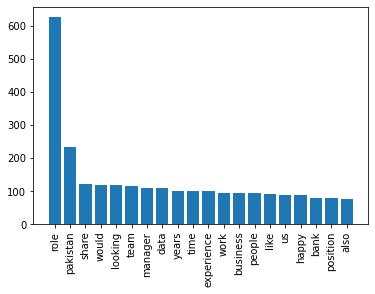

In [11]:
y20 = y.nlargest(20, 'count')
plt.bar(y20['word'], y20['count'])
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.show()

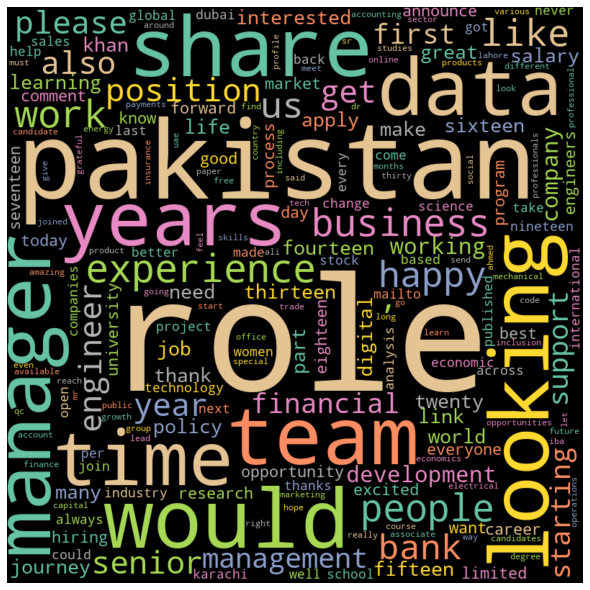

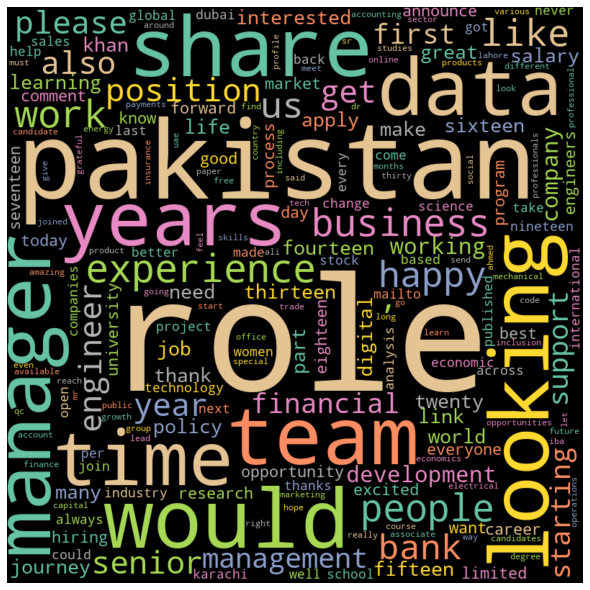

In [12]:
def make_wordcloud(new_text):
    ''''funciton to make wordcloud'''
    
    wordcloud = WordCloud(width = 800, height = 800, 
                min_font_size = 10,
                background_color='black', 
                colormap='Set2', 
                collocations=False).generate_from_frequencies(new_text) 
    
    #wordcloud.recolor(color_func = grey_color_func)

    
    fig = plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 
    
    return fig

y200 = y20.set_index('word').to_dict()['count']
y2000 = y.set_index('word').to_dict()['count']
make_wordcloud(y2000)

In [13]:
sentence = 'I love this weather'
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(sentence)

{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.6369}

In [14]:
def predict_sentiment(sentence):
    '''Predict sentiment and the confidentality of the predicted sentiment'''
    
    sid = SentimentIntensityAnalyzer()
    sentiment_dict = sid.polarity_scores(sentence)
    
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        return ("Positive", round(sentiment_dict['pos']*100, 2))
  
    elif sentiment_dict['compound'] <= - 0.05 : 
        return ("Negative", round(sentiment_dict['neg']*100, 2))
  
    else : 
        return ("Neutral", round(sentiment_dict['neu']*100, 2))

newproc = pd.DataFrame(processed, columns =['text'])
newproc['text'] = [' '.join([y for y in x.split() if y not in dl]) for x in newproc['text']]
newproce = newproc.text.to_list()
sentiment = [predict_sentiment(text) for text in newproce]
sentiment_df = pd.concat([pd.DataFrame(newproce, columns=['text']), pd.DataFrame(sentiment, columns=['Sentiment', 'Confident'])], axis=1)
sentiment_df.head(10)

,text,Sentiment,Confident
0,assurance gt program twenty-two apply away,Positive,52.9
1,looking rockstar profiles come join us activel...,Positive,20.9
2,apply away,Neutral,100.0
3,day day elated humbled share joined fs_minicom...,Positive,52.3
4,want link need get role,Positive,24.5
5,,Neutral,0.0
6,pakistanbased fs_minicompany68935711 b2b ecomm...,Negative,5.4
7,vopak accelerate lead program months culminati...,Positive,15.6
8,set fs_minicompany5177955 sports convention fs...,Positive,29.9
9,happy share starting position product owner fs...,Positive,49.6


(array([662.,   0.,   0.,   0.,   0., 103.,   0.,   0.,   0.,  47.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

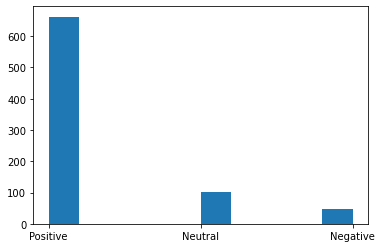

In [15]:
plt.hist(sentiment_df.Sentiment)